In [2]:
import os
import pickle
from pyproj import Transformer


import rioxarray
import numpy as np
import xarray as xr
import pandas as pd
from scipy import spatial

from pysheds.grid import Grid

import matplotlib
import matplotlib.pyplot as plt

label_size = 7
matplotlib.rcParams['xtick.labelsize'] = label_size
matplotlib.rcParams['ytick.labelsize'] = label_size
matplotlib.rc('font', size=6)

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

# Catchment characteristics

In this notebook, we will see how to extract specific catchments from model outputs and their main rivers longitudinal profiles.

## Basin dataset transformation & reprojection

In [ ]:
step = 0

# Open netcdf data file for a specific time step
out_path = 'export/unconstrained/'
dataset = xr.open_dataset(out_path+'data'+str(step)+'Ma.nc')

# We will only need the elevation array
ds = dataset[['elevation']] 

We clip the global dataset to a particular region of interest

In [5]:
minlon, maxlon = -72., -42.
minlat, maxlat = -40, -12.

# Define dataset bounds
mask_lon = (ds.longitude >= minlon) & (ds.longitude <= maxlon)
mask_lat = (ds.latitude >= minlat) & (ds.latitude <= maxlat)

# Extracting the corresponding elevation data
cropped_ds = ds.where(mask_lon & mask_lat, drop=True)

We then assign a coordinate referential system to the dataset (`CRS`) in order to reproject the data in a UTM system (metres instead of degrees)

In [6]:
# Define 
cropped_ds = cropped_ds.rio.write_crs(4326)
print('Default projection:',cropped_ds.rio.crs)
print('Estimated UTM projection:',cropped_ds.rio.estimate_utm_crs())

# Reproject
ds_utm = cropped_ds.rio.reproject(cropped_ds.rio.estimate_utm_crs())

Default projection: EPSG:4326
Estimated UTM projection: EPSG:32721


In [7]:
#ds_utm.elevation.where(ds_utm.elevation!=ds_utm.elevation.rio.nodata).plot()

Finally we save the projected dataset as a `geotiff`

In [8]:
# Taking the last time step of the elevation array
elevArray = ds_utm.elevation

# Assigning a value of -9999.0 to all point below sea-level
elevArray = elevArray.where(elevArray>0, other=-9999.0)

# Export to geotiff
tifout = os.path.join("view.tif")
elevArray.rio.to_raster(tifout)

## Extraction of geomorphometrics

In [9]:
def plotraster(grd, data, nd, label, v_min, v_max, cmap='Blues'):
    '''
    Simple plotting function to visualise the raster dataset
    '''
    data = np.ma.masked_array(data, mask = (data <= nd))
    
    plt.figure(figsize=(5,5))
    ax = plt.gca()
    im = plt.imshow(data, extent=grd.extent, cmap=cmap, vmin=v_min, vmax=v_max)
    plt.colorbar(im, label=label, shrink=0.5)
    plt.tight_layout()
    plt.show()
    
    return

We use the `pysheds` library that reads the `geotiff` we just created:

In [10]:
grid = Grid.from_raster(tifout, data_name='dem')
dem = grid.view('dem', nodata=-9999.0)
dem[dem == -9999] = np.nan

# Compute the depressions
grid.fill_depressions('dem', out_name='filled',
                      nodata_in = -9999, nodata_out = -9999)
filled = grid.view('filled', nodata = -9999).astype(np.float32)

# Resolve flat areas
grid.resolve_flats(data='filled', out_name='demnoflat',
                   nodata_in = -9999, nodata_out = -9999)
demnoflat = grid.view('demnoflat', nodata = -9999).astype(np.float32)

# Compute the flow direction
dirmap = (3, 2, 1, 8, 7, 6, 5, 4)
grid.flowdir('demnoflat', out_name='d8', dirmap=dirmap,
             nodata_in = -9999, nodata_out = -9999, pits = -9999, flats = -9999)
d8 = grid.view('d8', nodata = -9999).astype(np.float32)

# Compute the flow accumulation
grid.accumulation(data='d8', out_name='flowd8')
flowd8 = grid.view('flowd8', nodata = -9999).astype(np.float32)
flowd8[d8 == -9999] = -9999

Let’s visualise the generated outputs with our plotting function plotraster:

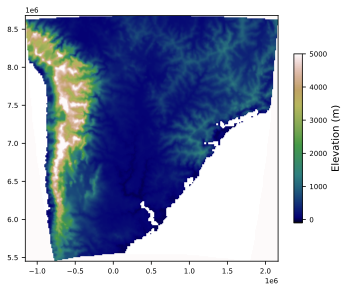

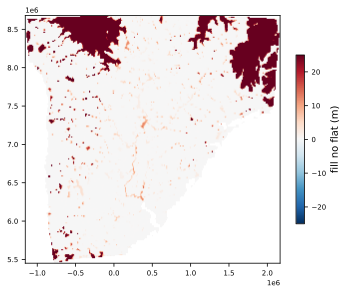

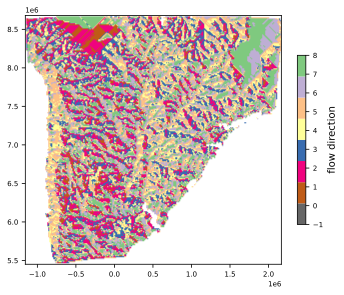

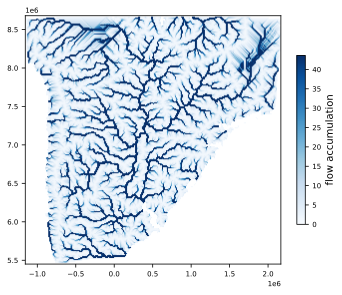

In [11]:
plotraster(grid, dem, -9999, 'Elevation (m)', -100, 5000, 'gist_earth')
plotraster(grid, demnoflat - dem, -9999, 'fill no flat (m)', -25, 25, 'RdBu_r')
plotraster(grid, d8, -9999, 'flow direction', -1, 8, 'Accent_r')
plotraster(grid, flowd8, -9999, 'flow accumulation', 0, np.max(flowd8)/1000, 'Blues')

## Extracting specific outlets

To extract specific catchments, `pysheds` requires the position of the outlet.

Here we show how to extract a specific outlet based on the flow accumulation values.

In [12]:
# Find the point ID corresponding to the maximum flow accumulation value
outletID = np.where(flowd8.flatten() == flowd8.max())[0]

# Get the corresponding point coordinate
outletPt = dem.coords[outletID,:][0]

# Define this first outlet by x1,y1
x1, y1 = outletPt[1], outletPt[0]

Let’s see where these 2 outlets are:

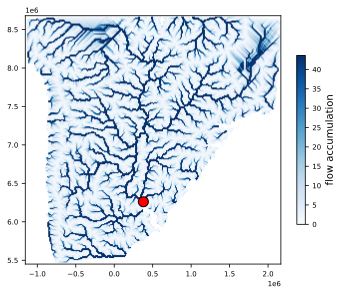

In [13]:
data = np.ma.masked_array(flowd8, mask = (flowd8 <= -9999))
    
plt.figure(figsize=(5,5))
ax = plt.gca()
im = plt.imshow(data, extent=grid.extent, cmap='Blues', vmin=0, vmax=np.max(flowd8)/1000)

plt.plot(x1,y1, 'o', color='red', markersize=10, 
         markeredgecolor='k', markeredgewidth=1)

plt.colorbar(im, label='flow accumulation', shrink=0.5)

plt.tight_layout()
plt.show()


## Get corresponding catchments

We now define a function `getCatchment` which extract river network (up to a specified flow accumulation `threshold`).

In [14]:
def getCatchment(geotiff, x, y, threshold):
    '''
    Extract a specific river network based on outlet position and flow accumulation threshold.
    '''
    
    grd = Grid.from_raster(geotiff, data_name='dem')

    grd.fill_depressions('dem', out_name='filled',
                          nodata_in = -9999, nodata_out = -9999)
    grd.resolve_flats(data='filled', out_name='inflated_dem')

    dirmap = (3, 2, 1, 8, 7, 6, 5, 4)
    grd.flowdir('inflated_dem', out_name='dir', dirmap=dirmap,
                  nodata_in = -9999, nodata_out = -9999, 
                  pits = -9999, flats = -9999)
    
    grd.accumulation(data='dir', out_name='acc2')

    acc2 = grd.view('acc2', nodata = -9999).astype(np.float32)
    acc2[acc2==0] = -9999
    
    grd.catchment(data='dir', x=x, y=y, out_name='catch',
                    recursionlimit=15000, xytype='label')

    
    grd.clip_to('catch', pad=(1,1,1,1))

    grd.accumulation(data='catch', out_name='acc')
    
    acc = grd.view('acc', nodata = -9999).astype(np.float32)
    acc[acc==0] = -9999
    
    branches = grd.extract_river_network('catch', 'acc', dirmap=dirmap, threshold=threshold, 
                                       nodata_in=-9999, routing='d8',
                                       apply_mask=True)
    
    data = np.ma.masked_array(acc, mask = (acc <= -9999))
    
    plt.figure(figsize=(5,5))
    ax = plt.gca()
    im = plt.imshow(data, extent=grd.extent, cmap='Blues', vmin=0, vmax=np.max(acc)/100)

    plt.plot(x, y, 'o', color='r', markersize=10, markeredgecolor='k', markeredgewidth=1)
    
    plt.colorbar(im, label='flow accumulation', shrink=0.5)

    plt.grid()
    plt.tight_layout()
    plt.show()
    
    tree = spatial.cKDTree(dem.coords, leafsize=10)
    
    branch_df = []
    nbbranches = len(branches['features'])
    
    for b in range(nbbranches):
        branch = branches['features'][b]
        branchXY = np.asarray(branch['geometry']['coordinates'])
        branchXY = np.flip(branchXY,1)
        dist, id = tree.query(branchXY, k=1)
        elev = demnoflat.flatten()[id]
        fa = acc2.flatten()[id]

        data = np.vstack((branchXY[:,0], branchXY[:,1], 
                          elev, fa))
        df = pd.DataFrame(data.T,
                          columns = ['x','y','elev','fa'])
        df = df[df.fa > -9999]
        df = df.reset_index(drop=True)

        xx = df.x.to_numpy()
        yy = df.y.to_numpy()
        dx = xx[1:]-xx[:-1]
        dy = yy[1:]-yy[:-1]
        step_size = np.sqrt(dx**2+dy**2)
        cumulative_distance = np.concatenate(([0], np.cumsum(step_size)))
        df['dist'] = cumulative_distance

        branch_df.append(df)
        
    
    endbranch = None
    maxfa = -10000
    for b in range(nbbranches):
        if branch_df[b].fa[0] > maxfa:
            maxfa = branch_df[b].fa[0]
            endbranch = b
            
    newdf = []
    newdf.append(branch_df[endbranch])
    for b in range(nbbranches):
        if b != endbranch:
            newdf.append(branch_df[b])
        
    return branches, newdf


We call the function for the outlet that was defined previously. The function returns 2 variables:

1. a dictionnary containing the geometry and coordinates of the main rivers
2. a `pandas` dataframe containing for each river the associated flow and elevation information

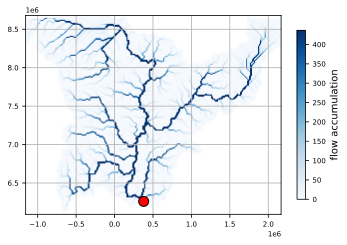

In [15]:
branches1, bdf1 = getCatchment(geotiff=tifout, x=x1, y=y1, threshold=500)

# Plotting river networks

The river networks can be obtained directly from the previous function first variable:

In [16]:
def plotBranch(branchnb):

    plt.figure(figsize=(5,5))
    ax = plt.gca()

    for branch in branchnb['features']:
        line = np.asarray(branch['geometry']['coordinates'])
        plt.plot(line[:, 0], line[:, 1], lw=3)

    plt.grid()
    plt.tight_layout()
    plt.show()
    
    return

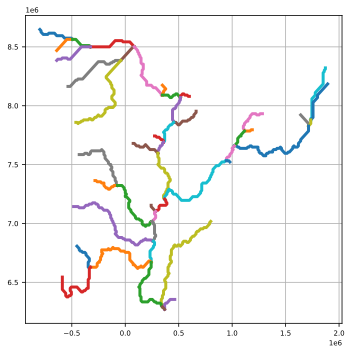

In [17]:
plotBranch(branches1)

## Longitudinal profiles

The second variable can be used to extract river longitudinal profile. To do so we define a new function `combineBranch` which connect each individual trunk together:

In [18]:
def combineBranch(branch_df):
    
    check = True
    
    pp = 0
    nbbranches = len(branch_df)
    while(check):
        for b in range(0,nbbranches):
            row1 = branch_df[b].iloc[0]
            x1, y1, dist1 = row1.x, row1.y, row1.dist

            lastrow = np.array(branch_df[b].tail(1))[0]
            xend, yend, distend = lastrow[0], lastrow[1], lastrow[-1]

            for nextb in range(0,nbbranches):
                if nextb != b:
                    firstrow = branch_df[nextb].iloc[0]
                    xstart, ystart, diststart = firstrow.x, firstrow.y, firstrow.dist
                    changed = False
                    if diststart == 0:
                        if abs(xstart-xend) < 1. and abs(ystart-yend) < 1.0:
                            if b == 0:
                                branch_df[nextb].dist += distend
                                changed = True
                            else:
                                if dist1 > 0.:
                                    branch_df[nextb].dist += distend
                                    changed = True
                        if not changed:
                            if abs(xstart-x1) < 1. and abs(ystart-y1) < 1.0:
                                if b == 0:
                                    branch_df[nextb].dist += 0.0001
                                else:
                                    branch_df[nextb].dist += dist1            
        
        check = False
        for b in range(1,nbbranches):
            if branch_df[b].iloc[0].dist == 0.:
                check = True
                
        
    return branch_df

In [19]:
ndf1 = combineBranch(branch_df=bdf1)

In [20]:
def plotProfile(dataframe):
    '''
    Function for plotting the longitudinal profile.
    '''

    plt.figure(figsize=(10,3))
    ax = plt.gca()

    for branch in range(len(dataframe)-1,-1,-1):
        distance = np.asarray(dataframe[branch].dist)
        elev = np.asarray(dataframe[branch].elev)
        plt.plot(distance, elev, lw=3)
        
    plt.tight_layout()
    plt.show()
    
    return

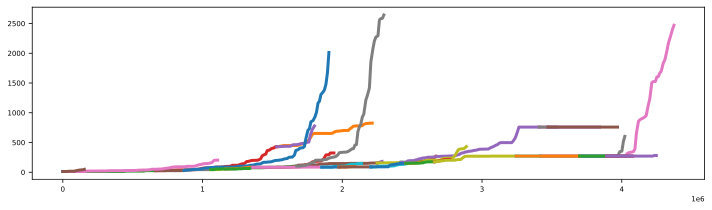

In [21]:
plotProfile(ndf1)

### Save dataset

In [22]:
trans = Transformer.from_crs(cropped_ds.rio.estimate_utm_crs(), cropped_ds.rio.crs)

for k in range(len(ndf1)):
    plat = np.zeros(len(ndf1[k]))
    plon = np.zeros(len(ndf1[k]))
    for p in range(len(ndf1[k])):
        plat[p],plon[p] = trans.transform(ndf1[k]['y'][p],ndf1[k]['x'][p])
    ndf1[k]['lon'] = plon
    ndf1[k]['lat'] = plat

In [23]:
with open('profile.data', 'wb') as filehandle:
    # store the data as binary data stream
    pickle.dump(ndf1, filehandle)

In [24]:
for feature in branches1['features']:
    coords = feature['geometry']['coordinates']
    for coordPair in coords:
        coordPair[0],coordPair[1] = trans.transform(coordPair[0], coordPair[1])
        
with open('branchesLonLat.data', 'wb') as f:
    pickle.dump(branches1, f)